In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [5]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']= 12,8

In [3]:
import os
os.getcwd()

'C:\\Users\\ancha\\Python Scripts\\Machine Learning'

In [4]:
os.chdir('C:\\Praxis\\Term-2\\AML\\gradient boosting')

### Fitting a GBM Classifier

In [6]:
train = pd.read_csv("train_modified.csv") #data cleaning and one hot encoding already done(Sir gave this data)
IDcol = 'ID'
target = 'Disbursed'

In [8]:
X = train.drop([target, IDcol], axis = 1) #Assuming we already have a train test split
y = train.Disbursed

In [11]:
#Baseline Model, random_state is not mandatory
gbm0 = GradientBoostingClassifier(random_state = 10)
gbm0.fit(X,y)

GradientBoostingClassifier(random_state=10)

In [12]:
#Prediction
pred = gbm0.predict(X)

In [13]:
#Training Accuracy
metrics.accuracy_score(y, pred)

0.9856010112617789

In [14]:
#AUC
probs = gbm0.predict_proba(X)[:,1]
metrics.roc_auc_score(y, probs)

0.8622636776374524

In [15]:
#perform cross validation, with folds = 10
cv_score = cross_val_score(gbm0, X, y, cv = 10, scoring = 'roc_auc' )
cv_score

array([0.82003352, 0.82687633, 0.83819931, 0.81106632, 0.8434035 ,
       0.84430798, 0.86006611, 0.82849904, 0.83114968, 0.83455979])

In [16]:
#printing our cv score summary
print("CV Score: Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" 
      % (np.mean(cv_score), np.std(cv_score),np.min(cv_score),np.max(cv_score)))

CV Score: Mean - 0.8338162 | Std - 0.01304561 | Min - 0.8110663 | Max - 0.8600661


In [17]:
#performing cross validation with 5 folds
cv_score = cross_val_score(gbm0, X, y, cv = 5, scoring = 'roc_auc' )
cv_score

array([0.82229288, 0.81954512, 0.84002108, 0.84384238, 0.8337214 ])

In [18]:
#printing cv score summary 
print("CV Score: Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" 
      % (np.mean(cv_score), np.std(cv_score),np.min(cv_score),np.max(cv_score)))

CV Score: Mean - 0.8318846 | Std - 0.009558541 | Min - 0.8195451 | Max - 0.8438424


### Defining a easy to use function for the above steps

In [20]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    
    #Fit the algorithm
    alg.fit(dtrain[predictors], dtrain['Disbursed']) #dtrain[predictors] = X, dtrain['Disbursed'] = y
    
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])  #prediction
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1] #AUC
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['Disbursed'],cv=cv_folds,
                                scoring='roc_auc')
    #Print model report
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'], dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    if performCV: #if performCV = False, this function will not work
        print("CV score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g"
      % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Print Feature Importance, if false this function will not work
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending =False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9856
AUC Score (Train): 0.862264
CV score : Mean - 0.8318999 | Std - 0.009537301 | Min - 0.8195451 | Max - 0.8438424


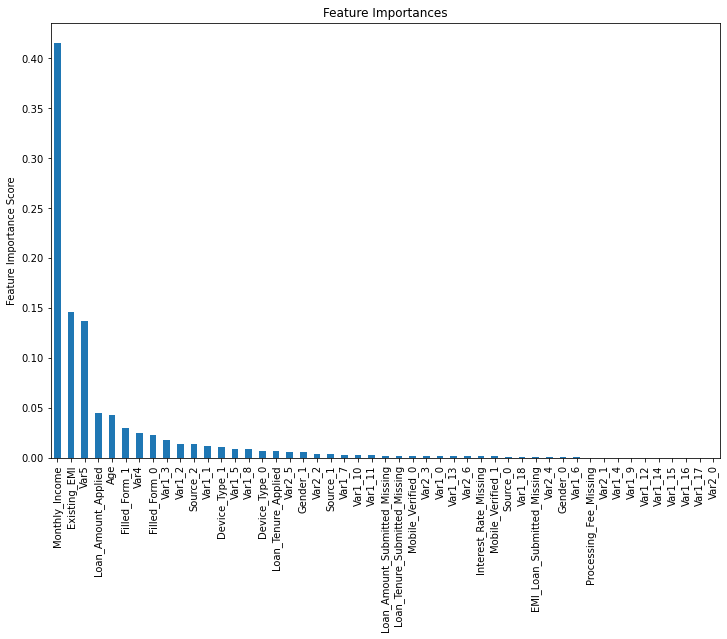

In [21]:
#Let's test our function
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier()
modelfit(gbm0, train, predictors)

### Hyperparameter Tuning, step 2 of Gradient boosting classifier

In [22]:
#Choose all predictors except target and IDcols, subsampling means you need to do select this proportion of your sample data  
#before you fit the model at every round. 
predictors = [x for x in train.columns if x not in [target, IDcol]]
param_test1 = {'n_estimators': range(20,81,10)} #n_estimators is for number of times i want my for loop to run

gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1, #alpha
                                                               min_samples_split=500,
                                                               min_samples_leaf=50,
                                                               max_depth=8,
                                                               max_features='sqrt',
                                                               subsample = 0.8),
                        param_grid = param_test1, scoring ='roc_auc',n_jobs=4, cv=5)

gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'n_estimators': range(20, 81, 10)},
             scoring='roc_auc')

In [29]:
print(gsearch1.best_params_ , gsearch1.best_score_)

{'n_estimators': 50} 0.8390356608955226


In [25]:
pd.DataFrame({'n_estimator': gsearch1.cv_results_['params'],
             'mean_test_score': gsearch1.cv_results_['mean_test_score']})

,n_estimator,mean_test_score
0,{'n_estimators': 20},0.834736
1,{'n_estimators': 30},0.835877
2,{'n_estimators': 40},0.835381
3,{'n_estimators': 50},0.839036
4,{'n_estimators': 60},0.837220
5,{'n_estimators': 70},0.837337
6,{'n_estimators': 80},0.838556


In [27]:
param_test2 = {'max_depth': range(5,16,2), 'min_samples_split': range(200,1001,150)} 

gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1,
                                                               n_estimators = 50,
                                                               max_features='sqrt',
                                                               subsample = 0.8),
                        param_grid = param_test2, scoring ='roc_auc',n_jobs=4, cv=5)

gsearch2.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  n_estimators=50,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(200, 1001, 150)},
             scoring='roc_auc')

In [28]:
print(gsearch2.best_params_, gsearch2.best_score_)

{'max_depth': 7, 'min_samples_split': 950} 0.8393514911852954


In [30]:
pd.DataFrame({'parameters': gsearch2.cv_results_['params'],
              'mean_test_score': gsearch2.cv_results_['mean_test_score'],
             'std_test_score':gsearch2.cv_results_['mean_test_score']})

,parameters,mean_test_score,std_test_score
0,"{'max_depth': 5, 'min_samples_split': 200}",0.832641,0.832641
1,"{'max_depth': 5, 'min_samples_split': 350}",0.832168,0.832168
2,"{'max_depth': 5, 'min_samples_split': 500}",0.832732,0.832732
3,"{'max_depth': 5, 'min_samples_split': 650}",0.832823,0.832823
4,"{'max_depth': 5, 'min_samples_split': 800}",0.833195,0.833195
5,"{'max_depth': 5, 'min_samples_split': 950}",0.832205,0.832205
6,"{'max_depth': 7, 'min_samples_split': 200}",0.836673,0.836673
7,"{'max_depth': 7, 'min_samples_split': 350}",0.834578,0.834578
8,"{'max_depth': 7, 'min_samples_split': 500}",0.834126,0.834126
9,"{'max_depth': 7, 'min_samples_split': 650}",0.837574,0.837574


In [31]:
param_test3 = {'min_samples_split': range(1000,2100,150), 'min_samples_leaf': range(30,71,10)} 

gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1,
                                                               n_estimators = 50,  #Fixed (we got this above)
                                                               max_depth = 7,      #Fixed (we got this above)
                                                               max_features='sqrt',
                                                               subsample = 0.8),
                        param_grid = param_test3, scoring ='roc_auc',n_jobs=4, cv=5)

gsearch3.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=7,
                                                  max_features='sqrt',
                                                  n_estimators=50,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'min_samples_leaf': range(30, 71, 10),
                         'min_samples_split': range(1000, 2100, 150)},
             scoring='roc_auc')

In [32]:
print(gsearch3.best_params_, gsearch3.best_score_)

{'min_samples_leaf': 60, 'min_samples_split': 1000} 0.8376483501193821


In [ ]:
# pd.DataFrame({'parameters': gsearch3.cv_results_['params'],
#               'mean_test_score': gsearch3.cv_results_['mean_test_score'],
#              'std_test_score':gsearch3.cv_results_['mean_test_score']})


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.877295
CV score : Mean - 0.8389529 | Std - 0.01239619 | Min - 0.8201839 | Max - 0.854666


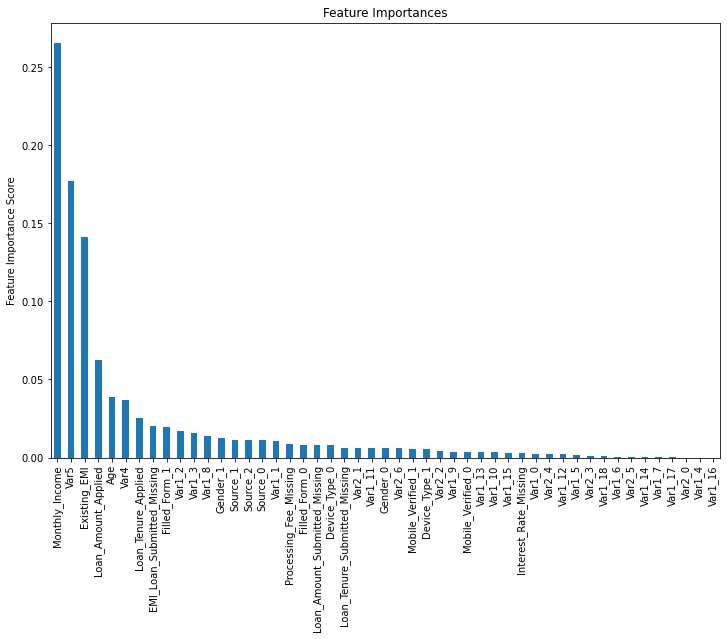

In [33]:
modelfit(gsearch3.best_estimator_,train,predictors)

In [34]:
param_test4 = {'max_features': range(7,30,3)} 

gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1,
                                                               n_estimators = 50,          #Fixed
                                                               min_samples_split=1000,     #Fixed
                                                               min_samples_leaf=60,        #Fixed
                                                               max_depth=7,                #Fixed
                                                               subsample = 0.8),
                        param_grid = param_test4, scoring ='roc_auc',n_jobs=4, cv=5)

gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=7,
                                                  min_samples_leaf=60,
                                                  min_samples_split=1000,
                                                  n_estimators=50,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'max_features': range(7, 30, 3)},
             scoring='roc_auc')

In [35]:
print(gsearch4.best_params_, gsearch4.best_score_)

{'max_features': 7} 0.837967209376032


In [ ]:
#modelfit(gsearch4.best_estimator_,train,predictors)

In [37]:
param_test5 = {'subsample': [0.6,0.7,0.75,0.8,0.85,0.9,1.0]} 

gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1,
                                                               n_estimators = 50,          #Fixed
                                                               min_samples_split=1000,     #Fixed
                                                               min_samples_leaf=60,        #Fixed
                                                               max_depth=7,
                                                               max_features =7,
                                                               subsample = 0.8),
                        param_grid = param_test5, scoring ='roc_auc',n_jobs=4, cv=5)

gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=7, max_features=7,
                                                  min_samples_leaf=60,
                                                  min_samples_split=1000,
                                                  n_estimators=50,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]},
             scoring='roc_auc')

In [38]:
print(gsearch5.best_params_, gsearch5.best_score_)

{'subsample': 0.9} 0.8379583039766366



Model Report
Accuracy : 0.9854
AUC Score (Train): 0.885197
CV score : Mean - 0.8389082 | Std - 0.01117777 | Min - 0.8215689 | Max - 0.8509972


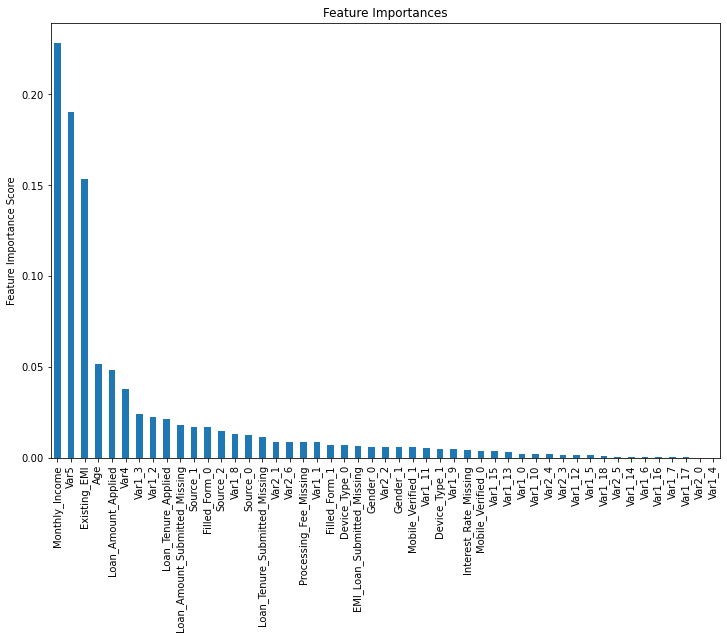

In [39]:
gbm_tuned_1 = GradientBoostingClassifier(learning_rate = 0.05,
                                         n_estimators = 120,          
                                         min_samples_split=1000,    
                                         min_samples_leaf=60,        
                                         max_depth=7,
                                         max_features =7,
                                         subsample = 0.9)

modelfit(gbm_tuned_1, train, predictors)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.886534
CV score : Mean - 0.8396387 | Std - 0.0104147 | Min - 0.8245987 | Max - 0.8520284


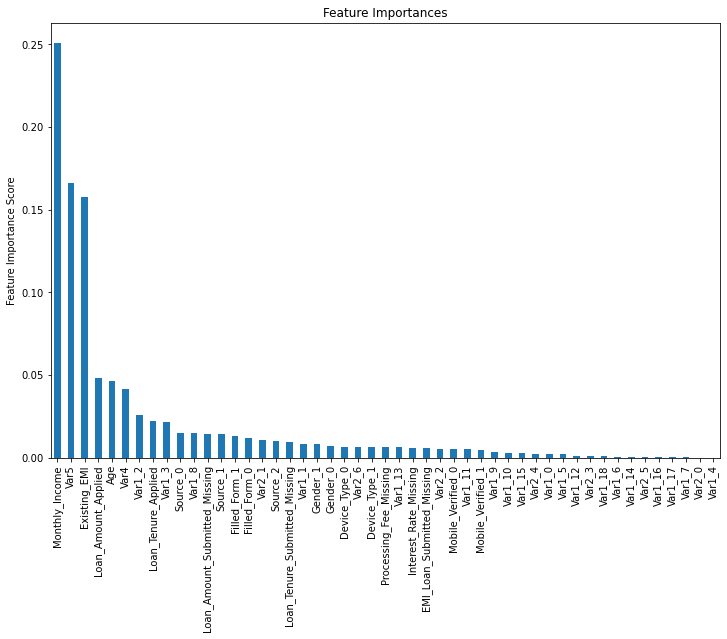

In [40]:
gbm_tuned_2 = GradientBoostingClassifier(learning_rate = 0.01,
                                         n_estimators = 600,          
                                         min_samples_split=1000,    
                                         min_samples_leaf=60,        
                                         max_depth=7,
                                         max_features =7,
                                         subsample = 0.9)

modelfit(gbm_tuned_2, train, predictors)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.885412
CV score : Mean - 0.8404275 | Std - 0.01023095 | Min - 0.8258531 | Max - 0.8522176


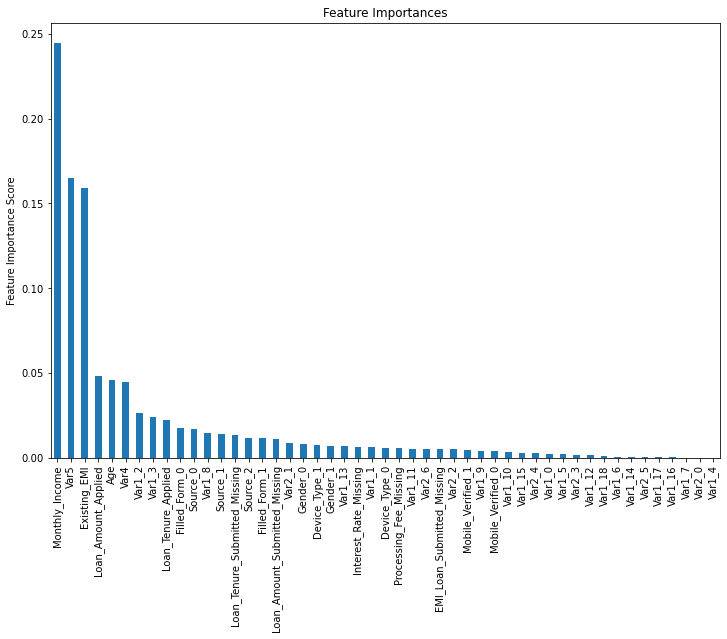

In [41]:
gbm_tuned_3 = GradientBoostingClassifier(learning_rate = 0.005,
                                         n_estimators = 1200,          
                                         min_samples_split=1000,    
                                         min_samples_leaf=60,        
                                         max_depth=7,
                                         max_features =7,
                                         subsample = 0.9)

modelfit(gbm_tuned_3, train, predictors)

In [ ]:
gbm_tuned_4 = GradientBoostingClassifier(learning_rate = 0.005,
                                         n_estimators = 1500,          
                                         min_samples_split=1000,    
                                         min_samples_leaf=60,        
                                         max_depth=7,
                                         max_features =7,
                                         subsample = 0.9)

modelfit(gbm_tuned_4, train, predictors)